In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.integrate as integrate
from scipy.optimize import curve_fit

## Data Import

Import from Daten_1.root the necessery informations as numpy arrays (Number of charged tracks, their momenta sum as a scalar, energy deposited in Ecal and Hcal). Additionally, the scattering angle of all events were imported as well as the beam energy.

In [2]:
path_data="data_z0experiment-main/data/daten_1.root"
file = uproot.open(path_data)
ttree = 'myTTree'
data_branches = file[ttree].arrays()

data_ctrk = ak.to_numpy(data_branches.Ncharged)
data_sump = ak.to_numpy(data_branches.Pcharged)
data_ecal = ak.to_numpy(data_branches.E_ecal)
data_hcal = ak.to_numpy(data_branches.E_hcal)
data_cos = ak.to_numpy(data_branches.cos_thet)
data_elep = ak.to_numpy(data_branches.E_lep)

This matrix here contains the informaitons from daten_1.lum about energies, luminosoties and their errors.

In [3]:
lumi_matrix = np.array([[88.48021,675.8590,3.502185,4.524100,5.721257],[89.47158,543.6270,3.179205,3.637000,4.830643],[90.22720,419.7760,2.810879,2.810400,3.974844],[91.23223,3122.204,7.786547,20.91518,22.31760],[91.97109,639.8380,3.567344,4.287300,5.577354],[92.97091,479.2400,3.121618,3.216000,4.481870],[93.71841,766.8380,3.972102,5.142000,6.497519]])

# Exercise 2

We copy and paste our identifictaion algorithm. It is unchanged from the algorithms and functions used in MC.

In [4]:
def particleID(ctrk,sump,ecal,hcal,details=False):
    had_count =0
    e_count = 0
    m_count = 0
    tau_count = 0
    
    if (8 <= ctrk <= 38): had_count += 1*3
    if (0 <= ctrk <= 4): e_count += 1
    if (2 <= ctrk <= 3): m_count += 1 * 2
    if (2 <= ctrk <= 7): tau_count += 1 * 2
        
    if (0 <= sump <= 80): had_count += 1
    if (0 <= sump <= 1) or (20 <= sump <= 1000): e_count += 1
    if (0 <= sump <= 1) or (70 <= sump <= 1000): m_count += 1 * 1.5
    if (5 <= sump <= 70): tau_count += 1 * 1.5
        
    if (20 <= ecal <= 90): had_count += 1 
    if (70 <= ecal <= 1000): e_count += 1 * 2
    if (1 <= ecal <= 11): m_count += 1
    if (11 <= ecal <= 75): tau_count += 1 
        
    if (3 <= hcal <= 50): had_count += 1
    if (0 <= hcal <= 7): e_count += 1
    if (0 <= hcal <= 14): m_count += 1
    if (0 <= hcal <= 35): tau_count += 1
        
    
    if details:
        print("Hadronic:",had_count,"Electron:",e_count,"Muon:",m_count,"Tau:",tau_count)
        
    return [had_count,e_count,m_count,tau_count]

def array_ID(ctrk,sump,ecal,hcal):
    
    result = []
    for i in range(0,len(ctrk)):
        result.append(particleID(ctrk[i],sump[i],ecal[i],hcal[i]))
    return result

def particle_ID_1234(ctrk,sump,ecal,hcal):
    namelist = []
    spare_list = []
    particle_list = array_ID(ctrk,sump,ecal,hcal)
    for particle in particle_list:
        name = []
        indices = [i for i, x in enumerate(particle) if x == max(particle)]
        if 0 in indices:
            name = 1
        if 1 in indices:
            name = 2
        if 2 in indices:
            name = 3
        if 3 in indices:
            name = 4
        if len(indices) != 1:
            name=0
            spare_list.append(np.array(indices)+1)
        namelist.append(name)
    return [namelist,spare_list]

def eff(id_array,Errorcounter=False):
    results = np.array([0,0,0,0])
    errors = 0
    for particle in id_array:
        if particle != 0:
            results[particle-1] += 1
        else:
            errors += 1
    
    if Errorcounter:
        print(errors)
    return results

Execute the particle identification to gain ID_array, which contains element wiese the ID of the particles. Again:
- qq / Hadronic = 1
- ee = 2
- mm = 3
- tt = 4

spare_array is to gain an idea of how many particles didnt got identified by the functions.

In [5]:
ID_array,spare_array = particle_ID_1234(data_ctrk,data_sump,data_ecal,data_hcal) 

## Inverse Matrix & and real number of events

We write down our effiency matrix from MC and also the matricies with the errors from MC. The first one is also inverted.

In [6]:
#np.linalg.inv

eff_matrix = np.array([[9.86881487e-01, 1.11603746e-04, 5.07289754e-05, 1.12415409e-02],
                       [9.59467815e-05, 9.70437731e-01, 1.06500927e-02, 1.80486557e-02],
                       [1.16548882e-04, 1.37739587e-04, 9.66614043e-01, 3.30998824e-02],
                       [0.00806676, 0.00409019, 0.008193,   0.97792057]])

mat_error = [[4.46027387e-03, 3.36516731e-05, 2.26872629e-05, 3.39612305e-04],
            [3.19835191e-05, 4.31063693e-03, 3.38422751e-04, 4.41883609e-04],
            [3.51425317e-05, 3.82043001e-05, 4.30872185e-03, 6.00387342e-04],
            [0.00031965, 0.00022743, 0.00032215, 0.00416919]]

inv_eff_matrix = np.linalg.inv(eff_matrix)

Here we run the algorithm to gain the errors of the inverted effiency matrix. The methode is the MC Toy experiment presented in this laboratory.

In [7]:
from scipy.optimize import curve_fit

matrix = eff_matrix
matrix_inv= np.linalg.inv(matrix)
error_matrix = np.array(mat_error)


### Number of toy experiments to be done
ntoy = 10000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))
    
    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    #print(inverse_toys.item(0,0),inverse_toy.item(0,0))
    # Append values
    inverse_toys = np.dstack((inverse_toys,inverse_toy))

Erros for the inverse matrix:
[[4.59855117e-03 3.55502033e-05 2.42235306e-05 3.66394136e-04]
 [3.43184091e-05 4.60577822e-03 3.68887010e-04 4.79869927e-04]
 [3.90369021e-05 4.13005346e-05 4.69459134e-03 6.67756907e-04]
 [3.39950678e-04 2.41241843e-04 3.49518456e-04 4.37057670e-03]]


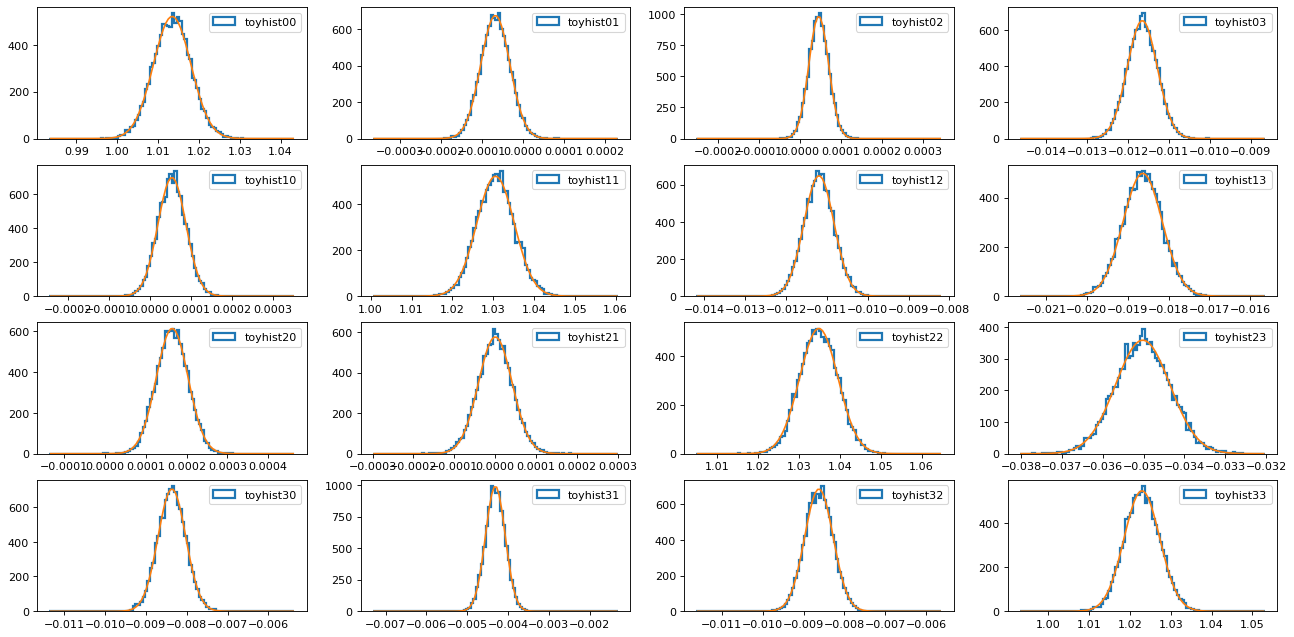

In [8]:
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))


fig = plt.figure(figsize=(20, 10),dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4,4,1)
ax01 = plt.subplot(4,4,2)
ax02 = plt.subplot(4,4,3)
ax03 = plt.subplot(4,4,4)

ax10 = plt.subplot(4,4,5)
ax11 = plt.subplot(4,4,6)
ax12 = plt.subplot(4,4,7)
ax13 = plt.subplot(4,4,8)

ax20 = plt.subplot(4,4,9)
ax21 = plt.subplot(4,4,10)
ax22 = plt.subplot(4,4,11)
ax23 = plt.subplot(4,4,12)

ax30 = plt.subplot(4,4,13)
ax31 = plt.subplot(4,4,14)
ax32 = plt.subplot(4,4,15)
ax33 = plt.subplot(4,4,16)

axes = [[ax00,ax01,ax02,ax03],
        [ax10,ax11,ax12,ax13],
        [ax20,ax21,ax22,ax23],
        [ax30,ax31,ax32,ax33]]
dx=0.03
dx1=0.003
dx2=0.0003
## IMPORTANT! Find suitable ranges to fit/plot gaussian distributions successfully!
ranges = [[(matrix_inv[0][0]-dx,matrix_inv[0][0]+dx),(matrix_inv[0][1]-dx2,matrix_inv[0][1]+dx2), (matrix_inv[0][2]-dx2,matrix_inv[0][2]+dx2), (matrix_inv[0][3]-dx1,matrix_inv[0][3]+dx1)],
          [(matrix_inv[1][0]-dx2,matrix_inv[1][0]+dx2),(matrix_inv[1][1]-dx,matrix_inv[1][1]+dx), (matrix_inv[1][2]-dx1,matrix_inv[1][2]+dx1), (matrix_inv[1][3]-dx1,matrix_inv[1][3]+dx1)],
          [(matrix_inv[2][0]-dx2,matrix_inv[2][0]+dx2),(matrix_inv[2][1]-dx2,matrix_inv[2][1]+dx2), (matrix_inv[2][2]-dx,matrix_inv[2][2]+dx), (matrix_inv[2][3]-dx1,matrix_inv[2][3]+dx1)],
          [(matrix_inv[3][0]-dx1,matrix_inv[3][0]+dx1),(matrix_inv[3][1]-dx1,matrix_inv[3][1]+dx1), (matrix_inv[3][2]-dx1,matrix_inv[3][2]+dx1), (matrix_inv[3][3]-dx,matrix_inv[3][3]+dx)]]


# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:],bins=100,range=ranges[j][k],  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        axes[j][k].legend()

        ## Guess initial parameters of the fit by taking random value from hist and std
        _p0 = [ntoy/10.,np.mean(inverse_toys[j,k,:]),np.std(inverse_toys[j,k,:])]
        if j==k:
            sig=dx
        else:
            sig=dx2
            
        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, p0=[600,matrix_inv[j][k],sig], maxfev=100000)
        h_fit = gauss(h_mid, *coeffs)
        
        axes[j][k].plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

## Getting the event numbers for different energies

For  the cross section a particular problem arose when we compared the energies of the measured luminosities and the energies of the events: they differ. This means that we have the luminosities only for energy values close to the of the events, but not exaclty for these events.

We first try to tackle this issue by fit a gaussian fit with a $x^2$-polynome through the luminosity by energy, but this fit resulted in an unusable equation.


2nd we assigned a energy value from the pool of energies with a known luminosity to the events. The criteria for the assignment was which energy is the closest to its energy in the data file. Therefore each event had one of seven energies and a corresponding luminosity. This resulted in a 7x4 matrix: one row for each particle, 7 collums for each energy and the number within is the amount of events fitting these criteria.

Another challenge is to us the s/t-channel seperation. The technique which we used was cutting the parts were the t channel is higher than 10% of the s channel. This resulted in cutting all data below $cos(\theta)=-0.9$ and above $cos(\theta)=0.1$. Since we were aware of therefore also loosing s-channel events we compensated for by multipling each counted electron event with a weight that corresponds to the area ratio of the area inside our cuts and the total area of the s-channel calculated by integrating the fit of the s-channel.

In [9]:
lumi_liste = []
energy_list = []
for element in data_elep*2:
    dist = np.abs(lumi_matrix[:,0] - element)
    #print(dist,element)
    indices = [i for i, x in enumerate(dist) if x == min(dist)]
    lumi_liste.append(lumi_matrix[indices[0],1])
    energy_list.append(lumi_matrix[indices[0],0])

In [92]:
qq_events = np.array([0,0,0,0,0,0,0])
ee_events = np.array([0,0,0,0,0,0,0])
mm_events = np.array([0,0,0,0,0,0,0])
tt_events = np.array([0,0,0,0,0,0,0])
lost_by_angle = 0
not_lost = 0

for number in range(0,len(ID_array)):
    if ID_array[number] == 1:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        qq_events[index[0]] += 1
    elif ID_array[number] == 2:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        if (-0.9 <= data_cos[number] <= 0.1):
            ee_events[index[0]] += 1 * 2.144772117962466
            not_lost += 1
        else:
            lost_by_angle += 1
    elif ID_array[number] == 3:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        mm_events[index[0]] += 1
    elif ID_array[number] == 4:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        tt_events[index[0]] += 1
        
print("Number of events per energy by particle ID")
print("qq",qq_events)
print("ee",ee_events)
print("mm",mm_events)
print("tt",tt_events)
print("Lost by angle:",lost_by_angle,"we accept:",not_lost)

Number of events per energy by particle ID
qq [ 3521  5315  7518 92445 15249  6619  7399]
ee [ 168  268  334 3542  544  196  286]
mm [ 190  297  375 4452  771  320  376]
tt [ 287  349  401 5357  904  416  459]
Lost by angle: 19838 we accept: 2669


Hereafter, the matrix with the counts was multiplied with the inverse effiency matrix to correct for the known effiencies of the ID functions. Also the error-matrix were calculated by multiplying the matrix of events after the s/t channel corrections with the error matrix of the inverese effiency matrix.

In [93]:
energy_events_matrix = np.array([qq_events,ee_events,mm_events,tt_events])

eff_energy_events_matrix = np.matmul(inv_eff_matrix,energy_events_matrix)
error_energy_events_matrix = np.matmul(inverse_errors,energy_events_matrix)
error_energy_events_matrix[1]*=np.sqrt(1+0.044537009229242114**2)
print("Event matrix after effiency correction:\n",eff_energy_events_matrix)
print("qq:",eff_energy_events_matrix[0])

Event matrix after effiency correction:
 [[ 3564.7936104   5382.08783443  7613.97524611 93620.2252647
  15442.62324128  6702.77134348  7492.70966826]
 [  165.84217479   266.63866774   332.92969595  3505.42039891
    535.94690066   191.00284617   282.36486206]
 [  187.14368409   295.99386615   375.25118257  4434.61714349
    768.69590642   317.66214683   374.23481812]
 [  261.81274752   308.88838813   342.71056431  4653.87230573
    788.34420502   366.64174917   403.24039565]]
qq: [ 3564.7936104   5382.08783443  7613.97524611 93620.2252647
 15442.62324128  6702.77134348  7492.70966826]


The cross section matrix is then defined by using the event number matrix and dividing the events by the luminosity corresponding to the energy.

In [103]:
cross_matrix = eff_energy_events_matrix / lumi_matrix[:,1]

Our equation:
$$\sigma = \frac{N}{L}$$
results in a  gaussian error propagation:
$$
\sigma_\sigma = \sqrt{\left(\frac{1}{L}\sigma_N\right)^2 + \left(\frac{N}{L^2}\sigma_L\right)^2}
$$

In [104]:
def error_prop(L,N,sN,sL):
    return np.sqrt((sN/L)**2 + (sL*N/L**2)**2)

error_cross = error_prop(lumi_matrix[:,1],eff_energy_events_matrix,error_energy_events_matrix,lumi_matrix[:,-1])
print("Error Matrix for cross section:\n",error_cross)
print("Cross section matrix:\n",cross_matrix)
#print(error_cross/cross_matrix)

Error Matrix for cross section:
 [[0.05075154 0.09891796 0.19064858 0.25430472 0.23748409 0.14555722
  0.09404618]
 [0.00264207 0.00535934 0.0090624  0.01105156 0.00936352 0.00479941
  0.00401025]
 [0.00296574 0.00591083 0.01012939 0.01359573 0.01291943 0.0075275
  0.00516425]
 [0.00500809 0.00818279 0.01325534 0.02120733 0.01836988 0.01135792
  0.00760046]]
Cross section matrix:
 [[ 5.27446348  9.90033209 18.13818619 29.98530053 24.13520804 13.98625186
   9.77091598]
 [ 0.24537984  0.49048091  0.79311275  1.12273906  0.83762906  0.39855364
   0.3682197 ]
 [ 0.27689752  0.5444797   0.89393196  1.4203483   1.20139146  0.66284564
   0.48802331]
 [ 0.38737776  0.56819913  0.81641295  1.49057278  1.2320997   0.7650483
   0.52584822]]


Here we apply the leptonic and hadronic corrections. The cross sections are then plotted.

In [105]:
xs_corrections = [[2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                  [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]]
cross_matrix[0] += xs_corrections[0]
cross_matrix[1] += xs_corrections[1]
cross_matrix[2] += xs_corrections[1]
cross_matrix[3] += xs_corrections[1]

print("Matrix of cross section after corrections:\n",cross_matrix)

Matrix of cross section after corrections:
 [[ 7.27446348 14.20033209 25.83818619 40.78530053 28.83520804 13.78625186
   8.17091598]
 [ 0.33537984  0.69048091  1.15311275  1.64273906  1.05762906  0.38855364
   0.2882197 ]
 [ 0.36689752  0.7444797   1.25393196  1.9403483   1.42139146  0.65284564
   0.40802331]
 [ 0.47737776  0.76819913  1.17641295  2.01057278  1.4520997   0.7550483
   0.44584822]]


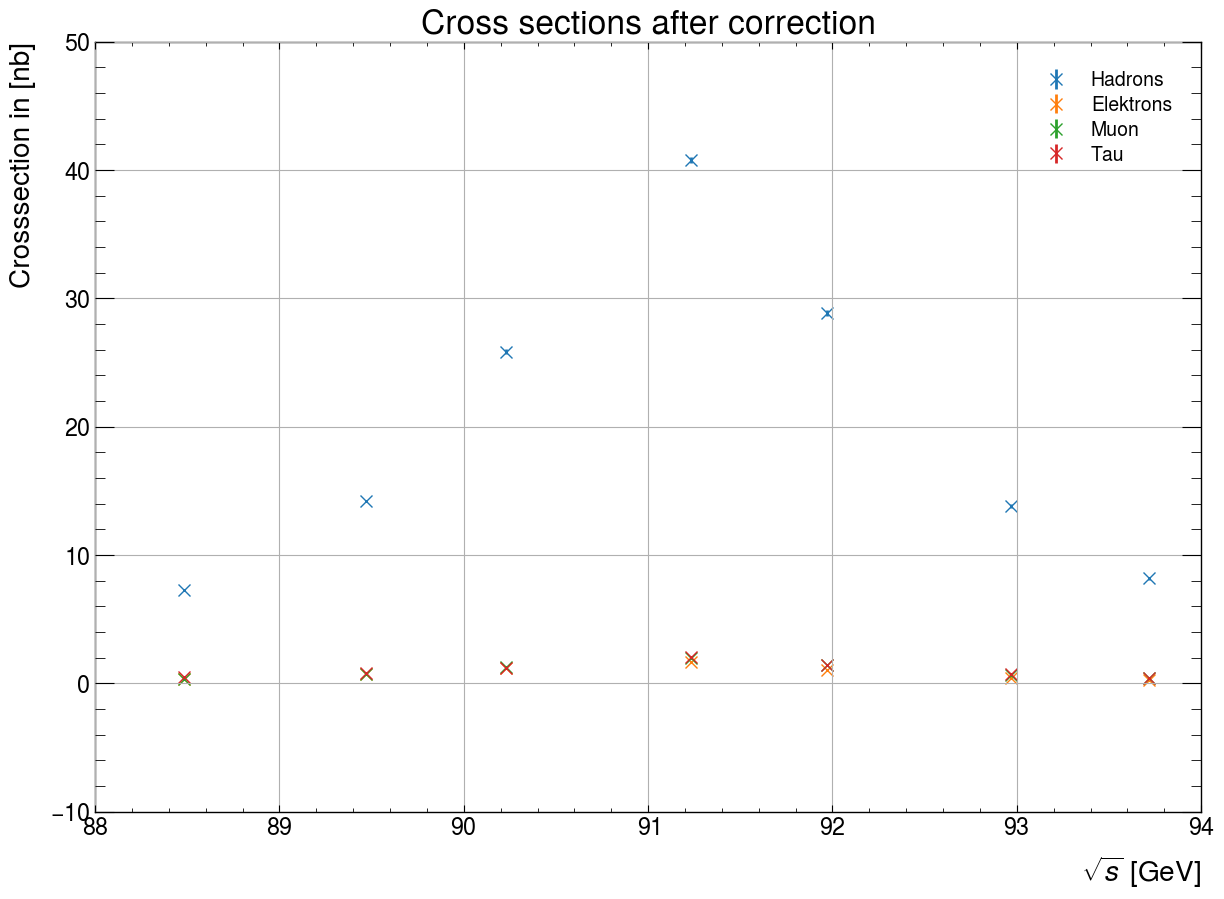

In [109]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(14,10))

plt.errorbar(lumi_matrix[:,0],cross_matrix[0],error_cross[0],ls="",marker="x",label='Hadrons')
plt.errorbar(lumi_matrix[:,0],cross_matrix[1],error_cross[1],ls="",marker="x",label='Elektrons')
plt.errorbar(lumi_matrix[:,0],cross_matrix[2],error_cross[2],ls="",marker="x",label='Muon')
plt.errorbar(lumi_matrix[:,0],cross_matrix[3],error_cross[3],ls="",marker="x",label='Tau')



plt.title(r'Cross sections after correction')
#plt.xlim(0,2)
plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.ylabel('Crosssection in [nb]')


#plt.ylim(0,20000)
plt.legend()
plt.grid()
plt.show()

## Crosssection fit

Now that we got the cross sections, we can make a fit with
$$
\sigma(s) = \frac{sa}{(s-b)^2+s^2c^2}
$$
with $a,b,c$ as our parameter. The fit was done with curve_fit from scipy. We analyzed the covarinaces to get a degree of confidence on our results.

However, we run into the issue, that the fits for parameter $c$, that is $\frac{\Gamma_z^2}{M_z^2}$ is not constant for the electronic fits. This is due to the good  fit applied to the bad data of cross section, we gained specificly only for electronic cross section. We are currently working on solving the issue of that. Possible candiates to explain this deviation are a falsy s/t-channel analysis and impliemntation, bad cuts or a data set with incredible amount of electronic events.

In [16]:
def breit_wigner(x,a,b,c):
    return x*a * 1/((x-b)**2 + x**2*c**2)

popt = []
pcov = []
for i in range(0,4):
    case_popt,case_pcov = curve_fit(breit_wigner,lumi_matrix[:,0]**2,2.56819*10**-6*cross_matrix[i],p0=[10**-4,8300,10**-2],sigma=2.56819*10**-6*error_cross[i],maxfev=1000000)
    popt.append(case_popt)
    pcov.append(case_pcov)


In [17]:
print("_________________________________________________________")
print("Fit results:")
print("Event|       a       |       b       |       c      ")
print("qq: ",popt[0])
print("ee: ",popt[1])
print("mm: ",popt[2])
print("tt: ",popt[3])
print("_________________________________________________________")
print("Covariance matricies:")
print("qq:\n",pcov[0])
print("ee:\n",pcov[1])
print("mm:\n",pcov[2])
print("tt:\n",pcov[3])
print("_________________________________________________________")
#print(popt[1][2]/popt[2][2],popt[1][2]/popt[3][2] )

_________________________________________________________
Fit results:
Event|       a       |       b       |       c      
qq:  [6.70994725e-04 8.31563667e+03 2.78283110e-02]
ee:  [2.55502791e-05 8.27551559e+03 2.67186309e-02]
mm:  [3.42178064e-05 8.31207880e+03 2.87518843e-02]
tt:  [4.24232854e-05 8.31917751e+03 3.27999469e-02]
_________________________________________________________
Covariance matricies:
qq:
 [[4.47362102e-11 3.73393873e-06 1.27209568e-09]
 [3.73393873e-06 2.00956497e+00 9.30150049e-05]
 [1.27209568e-09 9.30150049e-05 4.63468484e-08]]
ee:
 [[3.44297245e-12 4.57169380e-06 2.54899333e-09]
 [4.57169380e-06 8.18542714e+01 3.01479439e-03]
 [2.54899333e-09 3.01479439e-03 2.36945610e-06]]
mm:
 [[5.43341605e-13 7.75485237e-07 3.12385928e-10]
 [7.75485237e-07 9.16568559e+00 3.83001120e-04]
 [3.12385928e-10 3.83001120e-04 2.26873293e-07]]
tt:
 [[1.80898282e-11 1.82772680e-05 9.81109699e-09]
 [1.82772680e-05 1.92051395e+02 7.43833150e-03]
 [9.81109699e-09 7.43833150e-03 6.454

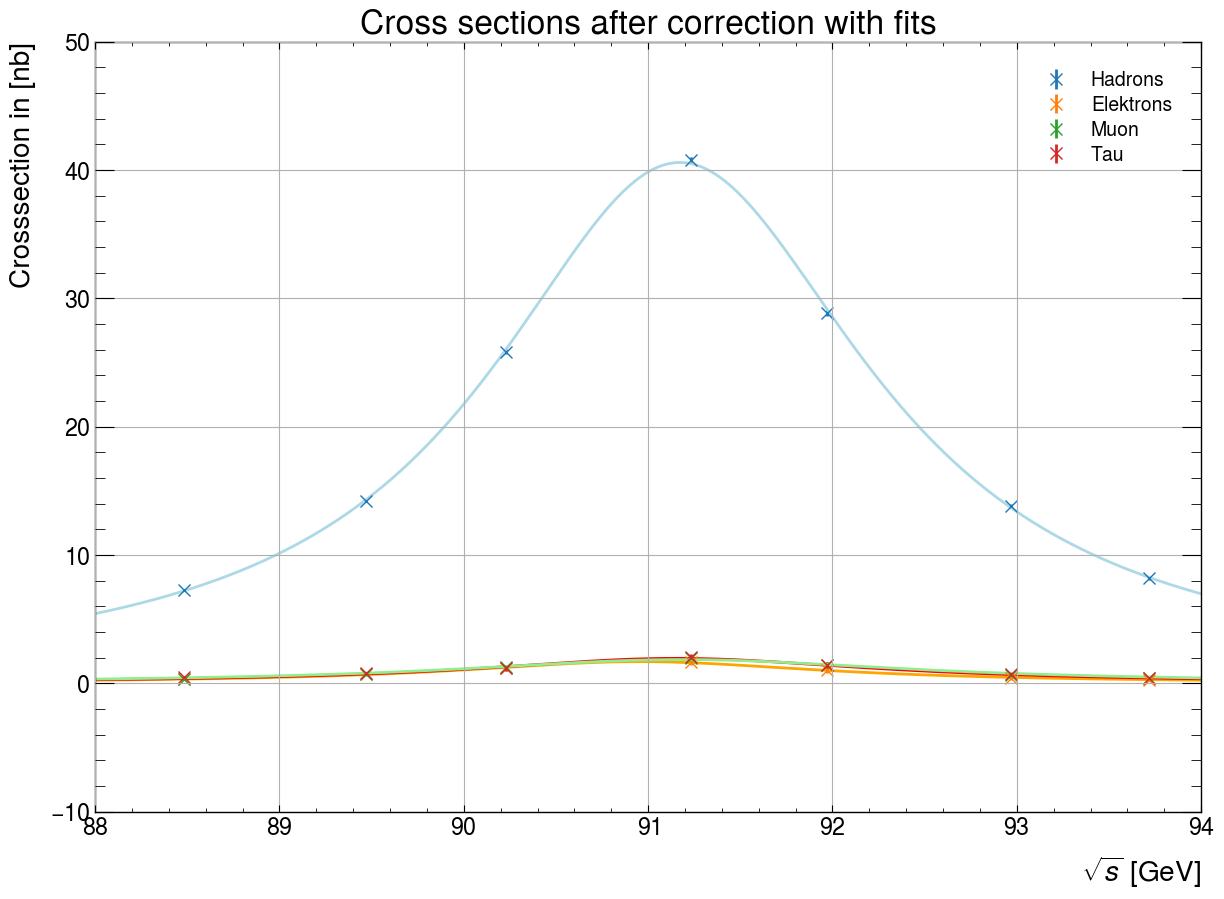

In [110]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(14,10))

plt.errorbar(lumi_matrix[:,0],cross_matrix[0],error_cross[0],ls="",marker="x",label='Hadrons')
plt.errorbar(lumi_matrix[:,0],cross_matrix[1],error_cross[0],ls="",marker="x",label='Elektrons')
plt.errorbar(lumi_matrix[:,0],cross_matrix[2],error_cross[0],ls="",marker="x",label='Muon')
plt.errorbar(lumi_matrix[:,0],cross_matrix[3],error_cross[0],ls="",marker="x",label='Tau')

s = np.linspace(88,94,500)
plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s**2,*popt[0]),color="lightblue")
plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s**2,*popt[1]),color="orange")
plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s**2,*popt[2]),color="red")
plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s**2,*popt[3]),color="lightgreen")

plt.title(r'Cross sections after correction with fits')
#plt.xlim(0,2)
plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.ylabel('Crosssection in [nb]')


#plt.ylim(0,20000)
plt.legend()
plt.grid()
plt.show()

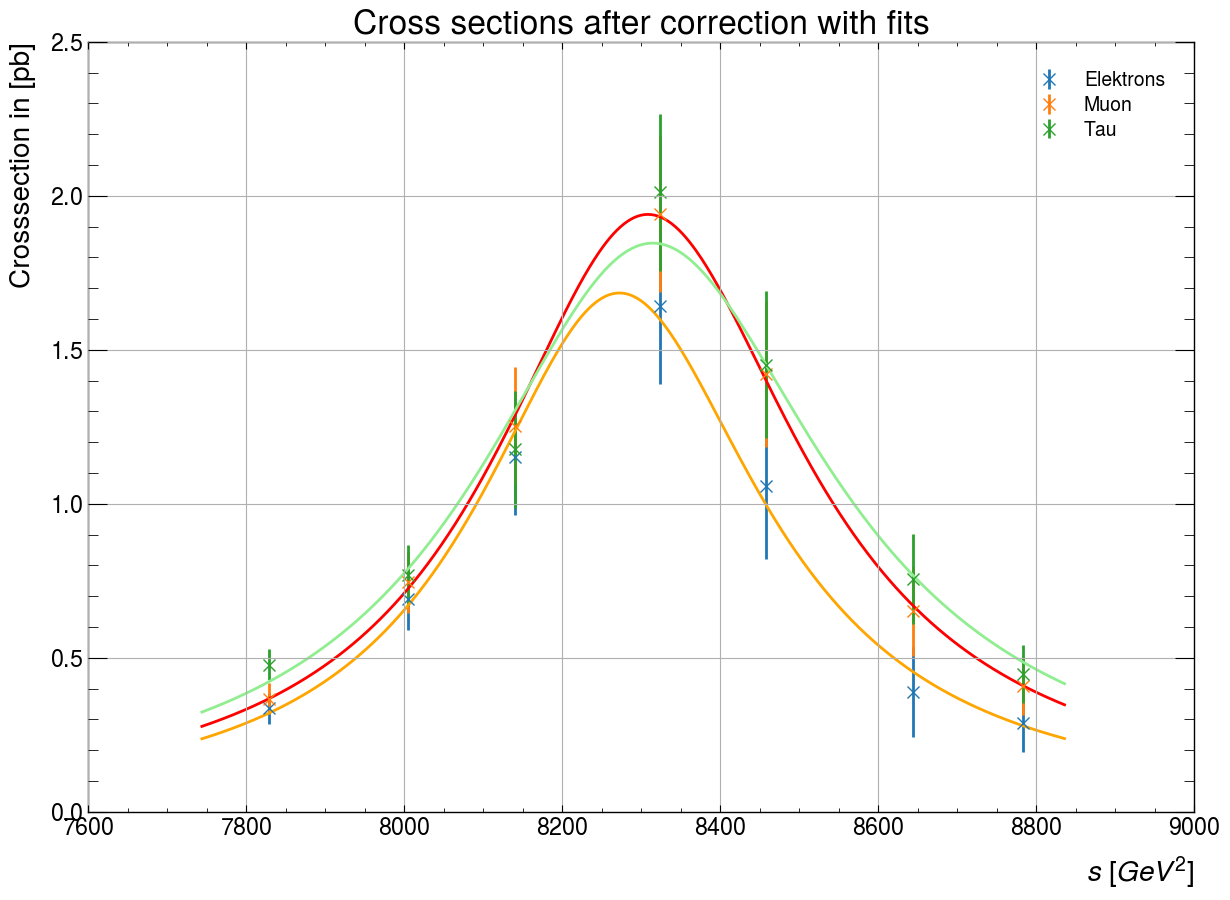

In [115]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(14,10))

#plt.errorbar(lumi_matrix[:,0],cross_matrix[0],error_cross[0],ls="",marker="x",label='Hadrons')
plt.errorbar(lumi_matrix[:,0]**2,cross_matrix[1],error_cross[0],ls="",marker="x",label='Elektrons')
plt.errorbar(lumi_matrix[:,0]**2,cross_matrix[2],error_cross[0],ls="",marker="x",label='Muon')
plt.errorbar(lumi_matrix[:,0]**2,cross_matrix[3],error_cross[0],ls="",marker="x",label='Tau')

s = np.linspace(88,94,500)**2
#plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s**2,*popt[0]),color="lightblue")
plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s,*popt[1]),color="orange")
plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s,*popt[2]),color="red")
plt.plot(s,1/(2.56819*10**-6)*breit_wigner(s,*popt[3]),color="lightgreen")

plt.title(r'Cross sections after correction with fits')
#plt.xlim(0,2)
plt.xlabel(r'$s$ [$GeV^2$]')
plt.ylabel('Crosssection in [pb]')


#plt.ylim(0,20000)
plt.legend()
plt.grid()
plt.show()

## Mass Z Boson

Now, we begin the analysis of the parameters by extracing the mass $M_Z$ from the fit parameter $b$ with:
$$
M_Z = \sqrt{b}
$$
The final result is the medium of all four masses gain from the four channels of our analysis.

In [84]:
M_z_qq=np.sqrt(popt[0][1])
M_z_ee=np.sqrt(popt[1][1])
M_z_mm=np.sqrt(popt[2][1])
M_z_tt=np.sqrt(popt[3][1])
M_z_qq_error=pcov[0][1][1]/np.sqrt(popt[0][1])
M_z_ee_error=pcov[1][1][1]/np.sqrt(popt[1][1])
M_z_mm_error=pcov[2][1][1]/np.sqrt(popt[2][1])
M_z_tt_error=pcov[3][1][1]/np.sqrt(popt[3][1])
M_z_stat=(M_z_qq+M_z_ee+M_z_mm+M_z_tt)/4
M_z_stat_error=np.sqrt((M_z_qq_error**2+M_z_ee_error**2+M_z_mm_error**2+M_z_tt_error**2)/16)
print('Mass Z Boson',M_z_stat)
print('uncertainty Mass Z Boson',M_z_stat_error)

Mass Z Boson 91.13502541678201
uncertainty Mass Z Boson 0.5730294739246042


## Gamma Z

With the knowledge of $M_Z$ we can aquire $\Gamma_Z$ from parameter $c$ with:
$$
\Gamma_Z = \sqrt{b} * c
$$
Again, the medium of all four channels was calculated and serves as our final result.

In [85]:
gamma_z_qq=abs(np.sqrt(popt[0][1])*popt[0][2])
gamma_z_ee=np.sqrt(popt[1][1])*popt[1][2]
gamma_z_mm=np.sqrt(popt[2][1])*popt[2][2]
gamma_z_tt=np.sqrt(popt[3][1])*popt[3][2]
gamma_z_qq_error=np.sqrt((pcov[0][1][1]/np.sqrt(popt[0][1])*popt[0][2])**2+(np.sqrt(popt[0][1])*pcov[0][2][2])**2+2*abs(pcov[0][1][2]/np.sqrt(popt[0][1])))
gamma_z_ee_error=np.sqrt((pcov[1][1][1]/np.sqrt(popt[1][1])*popt[1][2])**2+(np.sqrt(popt[1][1])*pcov[1][2][2])**2+2*pcov[1][1][2]/np.sqrt(popt[1][1]))
gamma_z_mm_error=np.sqrt((pcov[2][1][1]/np.sqrt(popt[2][1])*popt[2][2])**2+(np.sqrt(popt[2][1])*pcov[2][2][2])**2+2*pcov[2][1][2]/np.sqrt(popt[2][1]))
gamma_z_tt_error=np.sqrt((pcov[3][1][1]/np.sqrt(popt[3][1])*popt[3][2])**2+(np.sqrt(popt[3][1])*pcov[3][2][2])**2+2*pcov[3][1][2]/np.sqrt(popt[3][1])) 
gamma_z_stat =(gamma_z_qq+gamma_z_ee+gamma_z_mm+gamma_z_tt)/4
gamma_z_stat_error =np.sqrt((gamma_z_qq_error**2+gamma_z_ee_error**2+gamma_z_mm_error**2+gamma_z_tt_error**2)/16)
print(gamma_z_qq)
print(gamma_z_ee)
print(gamma_z_mm)
print(gamma_z_tt)
print('Gamma Z:',gamma_z_stat)
print('uncertainty Gamma Z:',gamma_z_stat_error)

2.5376668189770744
2.4305901343232326
2.6213266223865737
2.9916675909709554
Gamma Z: 2.645312791664459
uncertainty Gamma Z: 0.018702846564709545


## Gamma f

From the third degree of freedom and with $M_Z$ a calculation of $\Gamma_f$ was now possible. Here we required to first extract the electronic width, because this one appears in all other channels as well and had to be calculated first. 
$$
\Gamma_e = \sqrt{\frac{ba}{ 12 \pi}}
$$
From this, the other partial width were aquired from:
$$
\Gamma_f = \frac{ba}{12 \pi \Gamma_e}
$$

In [89]:
Gamma_ee=np.sqrt(popt[1][1]*popt[1][0]/(12*np.pi))
Gamma_ee_error=np.sqrt((pcov[1][1][1]*np.sqrt(popt[1][0]/popt[1][1]/(12*np.pi)))**2+(pcov[1][0][0]*np.sqrt(popt[1][1]/popt[1][0]/(12*np.pi)))**2+2*pcov[1][0][1]/np.sqrt((12*np.pi)/popt[1][1]/popt[1][0]))
Gamma_mm=popt[2][1]*popt[2][0]/(12*np.pi)/Gamma_ee
Gamma_mm_error=np.sqrt((pcov[2][1][1]*popt[2][0]/Gamma_ee/(12*np.pi))**2+(pcov[2][0][0]*popt[2][1]/Gamma_ee/(12*np.pi))**2+2*pcov[2][0][1]/(12*np.pi)/Gamma_ee+Gamma_ee_error*popt[2][1]*popt[2][0]/(12*np.pi)/Gamma_ee**2)                     
Gamma_tt=popt[3][1]*popt[3][0]/(12*np.pi)/Gamma_ee
Gamma_tt_error=np.sqrt((pcov[3][1][1]*popt[3][0]/Gamma_ee/(12*np.pi))**2+(pcov[3][0][0]*popt[3][1]/Gamma_ee/(12*np.pi))**2+2*pcov[3][0][1]/(12*np.pi)/Gamma_ee+Gamma_ee_error*popt[3][1]*popt[3][0]/(12*np.pi)/Gamma_ee**2)                     
Gamma_lep =(Gamma_ee+Gamma_mm+Gamma_tt)/3
Gamma_lep_error =np.sqrt((Gamma_ee_error**2+Gamma_mm_error**2+Gamma_tt_error**2)/9)
Gamma_qq=popt[0][1]*popt[0][0]/(12*np.pi)/Gamma_ee
Gamma_qq_error=np.sqrt((pcov[0][1][1]*popt[0][0]/Gamma_ee/(12*np.pi))**2+(pcov[0][0][0]*popt[0][1]/Gamma_ee/(12*np.pi))**2+2*pcov[1][0][1]/(12*np.pi)/Gamma_ee+Gamma_ee_error*popt[1][1]*popt[1][0]/(12*np.pi)/Gamma_ee**2)                     
print('Gamma_ee:',Gamma_ee)
print('uncertainty Gamma_ee:',Gamma_ee_error)
print('Gamma_mm:',Gamma_mm)
print('uncertainty Gamma_mm:',Gamma_mm_error)
print('Gamma_tt:',Gamma_tt)
print('uncertainty Gamma_tt:',Gamma_tt_error)
print('Gamma_lep:',Gamma_lep)
print('uncertainty Gamma_lep:',Gamma_lep_error)
print('Gamma_qq:',Gamma_qq)
print('uncertainty Gamma_qq:',Gamma_qq_error)

Gamma_ee: 0.07489102862790213
uncertainty Gamma_ee: 0.0011106211949278102
Gamma_mm: 0.10073975760764735
uncertainty Gamma_mm: 0.03865895916060801
Gamma_tt: 0.12500396120812157
uncertainty Gamma_tt: 0.04330199090988185
Gamma_lep: 0.10021158248122368
uncertainty Gamma_lep: 0.019352895331992952
Gamma_qq: 1.976303760874533
uncertainty Gamma_qq: 0.033377953947007016


## peak cross section for hadronic events

With the knwoledge of $M_Z, \Gamma_f, \Gamma_Z$ the peak cross section was calculated with equation 15.

In [90]:
partial_decay_width_qq=1/(2.56819*10**-6)*12*np.pi*Gamma_lep*Gamma_qq/(M_z_stat**2*gamma_z_stat**2)
partial_decay_width_qq_error=1/(2.56819*10**-6)*np.sqrt((12*np.pi*Gamma_lep_error*Gamma_qq/(M_z_stat**2*gamma_z_stat**2))**2+(12*np.pi*Gamma_lep*Gamma_qq_error/(M_z_stat**2*gamma_z_stat**2))**2+(12*np.pi*Gamma_lep*Gamma_qq*M_z_stat_error/(M_z_stat**3*gamma_z_stat**2))**2+(12*np.pi*Gamma_lep*Gamma_qq*gamma_z_stat_error/(M_z_stat**2*gamma_z_stat**3))**2)
print('peak cross section for hadronic events',partial_decay_width_qq)
print('uncertainty peak cross section for hadronic events',partial_decay_width_qq_error)

peak cross section for hadronic events 50.020828817055744
uncertainty peak cross section for hadronic events 9.708452855208662


## number of light neutrino generations

The number of light neutrino generations could now be estiamted from the sum of all widths as well as the overall decay width of the $Z0$ since they are equal. Said number is a scalar pre-factor for the neutrino decay width. The neutrino decay width itself was taken from Table 1. 

In [91]:
gamma_nt=0.1677
gamma_nt_error=0
number_neutrino_generations=(gamma_z_stat-3*Gamma_lep-Gamma_qq)/gamma_nt
number_neutrino_generations_error=np.sqrt(((gamma_z_stat_error)/gamma_nt)**2+((3*Gamma_lep_error)/gamma_nt)**2+((Gamma_qq_error)/gamma_nt)**2+(gamma_nt_error*(gamma_z_stat-3*Gamma_lep-Gamma_qq)/gamma_nt**2)**2)
print('number of neutrino light generations',number_neutrino_generations)
print('uncertainty number of neutrino light generations',number_neutrino_generations_error)

number of neutrino light generations 2.196626615064132
uncertainty number of neutrino light generations 0.41462118791285024


Apperntly we found new physics :D

## peak cross section

These cross sections on the peak are not caulculated with Eq. 15, but with the fit paramters from our fit function at $\sqrt{s} = M_Z$:
$$
\sigma_{l}^{peak} = \frac{a}{c^2  M_Z^2}
$$

In [25]:
peak_cs_qq=1/(2.56819*10**-6)*popt[0][0]/popt[0][2]**2/M_z_stat**2
peak_cs_qq_error=np.sqrt((1/(2.56819*10**-6)*pcov[0][0][0]/popt[0][2]**2/M_z_stat**2)**2+(1/(2.56819*10**-6)*pcov[0][2][2]*popt[0][0]/popt[0][2]**3/M_z_stat**2)**2+(1/(2.56819*10**-6)*M_z_stat_error*popt[0][0]/popt[0][2]**2/M_z_stat**3)**2+1/(2.56819*10**-6)*2/M_z_stat**2*pcov[0][0][2]/popt[0][2]**3)
peak_cs_ee=1/(2.56819*10**-6)*popt[1][0]/popt[1][2]**2/M_z_stat**2
peak_cs_ee_error=np.sqrt((1/(2.56819*10**-6)*pcov[1][0][0]/popt[1][2]**2/M_z_stat**2)**2+(1/(2.56819*10**-6)*pcov[1][2][2]*popt[1][0]/popt[1][2]**3/M_z_stat**2)**2+(1/(2.56819*10**-6)*M_z_stat_error*popt[1][0]/popt[1][2]**2/M_z_stat**3)**2+1/(2.56819*10**-6)*2/M_z_stat**2*pcov[1][0][2]/popt[1][2]**3)
peak_cs_mm=1/(2.56819*10**-6)*popt[2][0]/popt[2][2]**2/M_z_stat**2
peak_cs_mm_error=np.sqrt((1/(2.56819*10**-6)*pcov[2][0][0]/popt[2][2]**2/M_z_stat**2)**2+(1/(2.56819*10**-6)*pcov[2][2][2]*popt[2][0]/popt[2][2]**3/M_z_stat**2)**2+(1/(2.56819*10**-6)*M_z_stat_error*popt[2][0]/popt[2][2]**2/M_z_stat**3)**2+1/(2.56819*10**-6)*2/M_z_stat**2*pcov[2][0][2]/popt[2][2]**3)
peak_cs_tt=1/(2.56819*10**-6)*popt[3][0]/popt[3][2]**2/M_z_stat**2
peak_cs_tt_error=np.sqrt((1/(2.56819*10**-6)*pcov[3][0][0]/popt[3][2]**2/M_z_stat**2)**2+(1/(2.56819*10**-6)*pcov[3][2][2]*popt[3][0]/popt[3][2]**3/M_z_stat**2)**2+(1/(2.56819*10**-6)*M_z_stat_error*popt[3][0]/popt[3][2]**2/M_z_stat**3)**2+1/(2.56819*10**-6)*2/M_z_stat**2*pcov[3][0][2]/popt[3][2]**3)
print(peak_cs_qq)
print(peak_cs_qq_error)
print(peak_cs_ee)
print(peak_cs_ee_error)
print(peak_cs_mm)
print(peak_cs_mm_error)
print(peak_cs_tt)
print(peak_cs_tt_error)

40.620720335055545
0.2660250910039813
1.6779130810600795
0.11243459331028005
1.940536209094486
0.03716450529947611
1.8486735507988743
0.1618783690605834


## Confidence levels

This is just to calculate the confidence level of all our values to theoretical data, taken from the Instructions and the "Precise Determination pf Z Resonance Parameters at LEP: 'Zedometry'" from the OPAL Collaboration (30. Nov. 2000, CERN-EP-2000-148). The confidence level where all quantified with the t-Test:
$$
t = \frac{|x_1 - x_2|}{\sqrt{dx_1^2 + dx_2^2}}
$$
with $x_1,x_2$ being the values we like to compare and $dx_1, dx_2$ their errors. This test deemes two values acceptable, if t is within $[0,2]$.

In [26]:
M_z_theo=91.182
Gamma_z_theo=0.299*2+0.378*3+3*0.1676+0.0838*3
Gamma_ee_theo=0.0838
Gamma_mm_theo=0.0838
Gamma_tt_theo=0.0838
Gamma_lep_theo=0.0838
Gamma_qq_theo=0.299*2+0.378*3
M_z_opal=91.1862
M_z_opal_error=0.0054
Gamma_z_opal=2.4945
Gamma_z_opal_error=0.0061
Gamma_ee_opal=0.08363
Gamma_ee_opal_error=0.00032
Gamma_mm_opal=0.08362
Gamma_mm_opal_error=0.00045
Gamma_tt_opal=0.08360
Gamma_tt_opal_error=0.00058
Gamma_lep_opal=0.08372
Gamma_lep_opal_error=0.00023
Gamma_qq_opal=1.7467
Gamma_qq_opal_error=0.0064

M_z_theo_con=abs(M_z_theo-M_z_stat)/M_z_stat_error
Gamma_z_theo_con=abs(Gamma_z_theo-gamma_z_stat)/gamma_z_stat_error
Gamma_ee_theo_con=abs(Gamma_ee_theo-Gamma_ee)/Gamma_ee_error
Gamma_mm_theo_con=abs(Gamma_mm_theo-Gamma_mm)/Gamma_mm_error
Gamma_tt_theo_con=abs(Gamma_tt_theo-Gamma_tt)/Gamma_tt_error
Gamma_lep_theo_con=abs(Gamma_lep_theo-Gamma_lep)/Gamma_lep_error
Gamma_qq_theo_con=abs(Gamma_qq_theo-Gamma_qq)/Gamma_qq_error
M_z_opal_con=abs(M_z_opal-M_z_stat)/np.sqrt(M_z_opal_error**2+M_z_stat_error**2)
Gamma_z_opal_con=abs(Gamma_z_opal-gamma_z_stat)/np.sqrt(Gamma_z_opal_error**2+gamma_z_stat_error**2)
Gamma_ee_opal_con=abs(Gamma_ee_opal-Gamma_ee)/np.sqrt(Gamma_ee_opal_error**2+Gamma_ee_error**2)
Gamma_mm_opal_con=abs(Gamma_mm_opal-Gamma_mm)/np.sqrt(Gamma_mm_opal_error**2+Gamma_mm_error**2)
Gamma_tt_opal_con=abs(Gamma_tt_opal-Gamma_tt)/np.sqrt(Gamma_tt_opal_error**2+Gamma_tt_error**2)
Gamma_lep_opal_con=abs(Gamma_lep_opal-Gamma_lep)/np.sqrt(Gamma_lep_opal_error**2+Gamma_lep_error**2)
Gamma_qq_opal_con=abs(Gamma_qq_opal-Gamma_qq)/np.sqrt(Gamma_qq_opal_error**2+Gamma_qq_error**2)

print('Comparison with Theorie')
print('confidence level Mass Z Boson:',M_z_theo_con)
print('confidence level Gamma Z Boson:',Gamma_z_theo_con)
print('confidence level Gamma elektron:',Gamma_ee_theo_con)
print('confidence level Gamma muon:',Gamma_mm_theo_con)
print('confidence level Gamma tauon:',Gamma_tt_theo_con)
print('confidence level Gamma lepton:',Gamma_lep_theo_con)
print('confidence level Gamma hadron:',Gamma_qq_theo_con)
print('Comparison with Opal Measurement')
print('confidence level Mass Z Boson:',M_z_opal_con)
print('confidence level Gamma Z Boson:',Gamma_z_opal_con)
print('confidence level Gamma elektron:',Gamma_ee_opal_con)
print('confidence level Gamma muon:',Gamma_mm_opal_con)
print('confidence level Gamma tauon:',Gamma_tt_opal_con)
print('confidence level Gamma lepton:',Gamma_lep_opal_con)
print('confidence level Gamma hadron:',Gamma_qq_opal_con)

Comparison with Theorie
confidence level Mass Z Boson: 0.0819758587569072
confidence level Gamma Z Boson: 8.507410415518759
confidence level Gamma elektron: 8.021611160299301
confidence level Gamma muon: 0.4381845237289344
confidence level Gamma tauon: 0.9515488859131996
confidence level Gamma lepton: 0.8480169090819768
confidence level Gamma hadron: 2.452960643311048
Comparison with Opal Measurement
confidence level Mass Z Boson: 0.08930135959568983
confidence level Gamma Z Boson: 7.6661809599669715
confidence level Gamma elektron: 7.560955533436258
confidence level Gamma muon: 0.44281062585630226
confidence level Gamma tauon: 0.9560818509765399
confidence level Gamma lepton: 0.8520904841300609
confidence level Gamma hadron: 2.589437834555727


## percentage deviation

In order to ease the later discussion we also calculated the deviation of our values to the values from OPAL in percent.

In [27]:
M_z_theo_per=abs(1-M_z_stat/M_z_theo)*100
Gamma_z_theo_per=abs(1-gamma_z_stat/Gamma_z_theo)*100
Gamma_ee_theo_per=abs(1-Gamma_ee/Gamma_ee_theo)*100
Gamma_mm_theo_per=abs(1-Gamma_mm/Gamma_mm_theo)*100
Gamma_tt_theo_per=abs(1-Gamma_tt/Gamma_tt_theo)*100
Gamma_lep_theo_per=abs(1-Gamma_lep/Gamma_lep_theo)*100
Gamma_qq_theo_per=abs(1-Gamma_qq/Gamma_qq_theo)*100
M_z_opal_per=abs(1-M_z_stat/M_z_opal)*100
Gamma_z_opal_per=abs(1-gamma_z_stat/Gamma_z_opal)*100
Gamma_ee_opal_per=abs(1-Gamma_ee/Gamma_ee_opal)*100
Gamma_mm_opal_per=abs(1-Gamma_mm/Gamma_mm_opal)*100
Gamma_tt_opal_per=abs(1-Gamma_tt/Gamma_tt_opal)*100
Gamma_lep_opal_per=abs(1-Gamma_lep/Gamma_lep_opal)*100
Gamma_qq_opal_per=abs(1-Gamma_qq/Gamma_qq_opal)*100


print('Comparison with Theorie')
print('percentage deviation Mass Z Boson:',M_z_theo_per)
print('percentage deviation Gamma Z Boson:',Gamma_z_theo_per)
print('percentage deviation Gamma elektron:',Gamma_ee_theo_per)
print('percentage deviation Gamma muon:',Gamma_mm_theo_per)
print('percentage deviation Gamma tauon:',Gamma_tt_theo_per)
print('percentage deviation Gamma lepton:',Gamma_lep_theo_per)
print('percentage deviation Gamma hadron:',Gamma_qq_theo_per)
print('Comparison with Opal Measurement')
print('percentage deviation Mass Z Boson:',M_z_opal_per)
print('percentage deviation Gamma Z Boson:',Gamma_z_opal_per)
print('percentage deviation Gamma elektron:',Gamma_ee_opal_per)
print('percentage deviation Gamma muon:',Gamma_mm_opal_per)
print('percentage deviation Gamma tauon:',Gamma_tt_opal_per)
print('percentage deviation Gamma lepton:',Gamma_lep_opal_per)
print('percentage deviation Gamma hadron:',Gamma_qq_opal_per)

Comparison with Theorie
percentage deviation Mass Z Boson: 0.051517386345978355
percentage deviation Gamma Z Boson: 6.399838776625333
percentage deviation Gamma elektron: 10.631230754293398
percentage deviation Gamma muon: 20.214507885020705
percentage deviation Gamma tauon: 49.1694047829613
percentage deviation Gamma lepton: 19.584227304562862
percentage deviation Gamma hadron: 14.725793910945374
Comparison with Opal Measurement
percentage deviation Mass Z Boson: 0.05612097358809187
percentage deviation Gamma Z Boson: 6.045812453977106
percentage deviation Gamma elektron: 10.449565194425281
percentage deviation Gamma muon: 20.47328104239099
percentage deviation Gamma tauon: 49.526269387705234
percentage deviation Gamma lepton: 19.698497946994365
percentage deviation Gamma hadron: 15.443450537446267


# Exercise 3 - Forward-backward asymmetry

The $A_{FB}$ (asymmetry forwards - backwards) for the muon channel was calculated by considering multiple different methodes and steps. Ultimatly, only one methode proofed feasible in our time frame.

Out of the three methodes we thought of the first to try was to get the form factors $F_1$ and $F_2$ from eqaution 20 in the english manual by fitting a function like equation 16 to the differential cross sections. In the end, this methode was negelcted because it was not feasible to calculate the differential cross sections in time with a high enough precision.

The second methode was to do a log-likelihood process to extract the $A_{FB}$. Therefore we would have used equation 16 again to calculate its log-likelihood function with  $A_{FB}$ as its free parameter. This was negelcted as well again due to time constrains and the issue of not finding an adequat replacement the differential cross sections.

The final methode was to count the amount of muon events that have been scattered in forward direction (we used $0 < cos(\theta)=<0.95$ as forward) and backwards ($0 >= cos(\theta) >=0.95$ as backward). The particle ID and its energy was taken over from the previouse exercises so all particles have the energies from the luminosity file. For each energy the total forward and backward cross section was then calculated with the luminosity of this energy and the counts. With these cross sections, the $A_{FB}$ was claculated using:
$$
A_{FB} = \frac{\sigma_F - \sigma_B}{\sigma_F + \sigma_B}
$$
The errors were agian done by gaussian error propagation.

In [28]:
afb_energy = []
afb_lumi = []
afb_cos = []
afb_mm_events = np.array([0,0,0,0,0,0,0])

for number in range(len(ID_array)):
    if ID_array[number] == 3:
        afb_energy.append(energy_list[number])
        afb_lumi.append(lumi_liste[number])
        afb_cos.append(data_cos[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        afb_mm_events[index[0]] += 1
        
print("Events",afb_mm_events)
print("Part of the energies:",afb_energy[:10])
print("Part of the angles:",afb_cos[:10])

Events [ 190  297  375 4452  771  320  376]
Part of the energies: [91.23223, 91.23223, 91.23223, 91.23223, 91.23223, 91.23223, 91.23223, 91.23223, 91.23223, 91.23223]
Part of the angles: [0.743892, 0.24391861, -0.8292758, -0.33065996, 0.7530103, 0.88201755, 999.0, -0.3486435, -0.07207853, -0.82583565]


In [29]:
afb_cos_matrix = [[],[],[],[],[],[],[]]
for number in range(len(afb_energy)):
    for point in range(len(lumi_matrix[:,0])):
        if afb_energy[number] == lumi_matrix[point,0]:
            afb_cos_matrix[point].append(afb_cos[number])
        else:
            None



In [30]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

In [73]:
afb_list = []
event_lists = []

for i in range(len(lumi_matrix[:,0])):
    fb_list = np.array([0,0]) 
    for angle in afb_cos_matrix[i]:
        if (0.95 >= angle > 0):
            fb_list[0] += 1
        elif (0 >= angle >= -0.95):
            fb_list[1] += 1
        elif angle > 0.95 or angle < -0.95:
            None
        else:
            print("Oops") 
    event_lists.append(fb_list)
    afb = (fb_list[0]/lumi_matrix[i,1]-fb_list[1]/lumi_matrix[i,1])/(np.sum(fb_list)/lumi_matrix[i,1])
    afb_list.append(afb)

afb_list += np.array([0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850])



#entry #0 is for angles >0 so it is scattered IN flight direction
#entry #1 is angley <= 0 so it is scattered AGAINST flight direction
#                   o
#                o
# -o--o--o--- X --------->
#          
# Entry #0 ,1>x>0 cos(),0<x<90 deg

# if (0.95 >= angle > 0):
#            fb_list[0] += 1
#        elif angle <= 0.95:
#            fb_list[1] += 1
#        elif angle > 0.95 or angle < 0.95:
#            None
#        else:

In [74]:
print(afb_list)
print(event_lists)

[-0.05435007  0.05894454 -0.10754736  0.01247169  0.02021406  0.26960341
  0.18807492]
[array([67, 78]), array([131, 121]), array([148, 190]), array([1964, 1987]), array([344, 351]), array([163, 107]), array([180, 149])]


## Errors

In [75]:
error_mm_selection = error_energy_events_matrix[2]

error_event_list = np.sqrt(event_lists)

error_fb_event_list = np.zeros([7,2])

for i in range(7):
    for j in range(2):
        error_fb_event_list[i,j] = np.sqrt((error_mm_selection[i])**2 + (error_event_list[i][j])**2)
        
def error_prop(L,N,sN,sL):
    return np.sqrt((sN/L)**2 + (sL*N/L**2)**2)

error_cross = np.zeros([7,2])

for i in range(7):
    for j in range(2):
        error_cross[i,j] = error_prop(lumi_matrix[i,1],event_lists[i][j],error_fb_event_list[i][j],lumi_matrix[i,-1])
        
error_afb = np.zeros([7])

for i in range(7):
    a = event_lists[i][0]/lumi_matrix[i,1]
    b = event_lists[i][0]/lumi_matrix[i,1]
    error_afb[i] = np.sqrt(( (2*b)/(a+b)**2 *error_cross[i,0])**2 + ( (2*a)/(a+b)**2*error_cross[i,1])**2)
    
print(error_afb)

[0.09102448 0.06170066 0.06357368 0.01962758 0.04007576 0.05148458
 0.05153326]


We also tried to fit a function through our data, in order to gain better insight in the dependence of $A_{FB}$ to $\sqrt{s}$. The basic correlation of $A_{FB} \approx \sqrt{s}$ is from "Precise Determination pf Z Resonance Parameters at LEP: 'Zedometry'" from the OPAL Collaboration (30. Nov. 2000, CERN-EP-2000-148). We used two additional degrees of freedome, one for a amplitude and the other one as y-axis boost.

0.0277113532400719


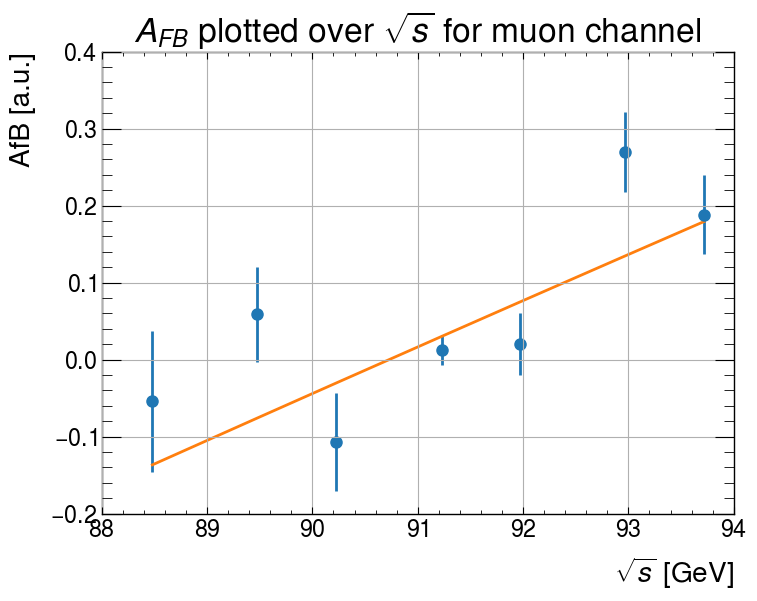

In [121]:
plt.errorbar(lumi_matrix[:,0],afb_list,yerr=error_afb,ls="",marker="o")
plt.xlabel(r"$\sqrt{s}$ [GeV]")
plt.ylabel(r"AfB [a.u.]")
plt.title(r"$A_{FB}$ plotted over $\sqrt{s}$ for muon channel")
plt.grid()

def afb_fun(s,a,b):
    return np.sqrt(s)*a+b

p11,p22 = curve_fit(afb_fun, lumi_matrix[:,0],afb_list,sigma=error_afb)

plt.plot(lumi_matrix[:,0], afb_fun(lumi_matrix[:,0],*p11 ))
print(afb_fun(91.1876,*p11 ))

# Weinberg Angle

The Weinberg angle can be calculated from the the forward-backward asymmtry around the $M_z$. Here we did not use the data from the fit through the $A_{FB}$-plot, but the energy, $A_{FB}$, and uncertainties from the data point at $91.23223$ GeV. The relation for Afb and Weinberg angle is:
$$
A_{FB}^{peak} = 3(v_l/a_l)^2 = 3(1-4sin^2(\theta_w))^2
$$
From this we extract a equation for $sin(\theta_w)^2$:
$$
sin(\theta_w)^2 = \frac{1-\sqrt{\frac{A_{FB}}{3}}}{4}
$$
The error calculation was doen with gaussian error propagation from the error on the Afb.

In [77]:
#m_z_stat = M_z_stat
m_z_stat = lumi_matrix[3,0]
#Afb_peak = afb_fun(m_z_stat,*p11 )
Afb_peak = afb_list[3]

afb_peak_error = error_afb[3]

print("The AfB at peak:",Afb_peak)
sin_afb = (1-np.sqrt(Afb_peak/3))/4
print("The sin()^2:",sin_afb)

#Error shit
weinberg_error = 1/(8*np.sqrt(3)*np.sqrt(Afb_peak)) * afb_peak_error
print("Error:",weinberg_error)

The AfB at peak: 0.012471688939509028
The sin()^2: 0.2338808544610318
Error: 0.012683920460862586


At last, a comparison to the literature value of $sin(\theta_w)^2 = 0.2312$ was done via t-Test (Source: Z0_english instructions).

In [78]:
weinberg_lit = 0.2312
weinberg_cov = np.abs(weinberg_lit-sin_afb)/weinberg_error
print("Distance:",weinberg_lit-sin_afb)
print("Comparision: T-Test:",weinberg_cov)

Distance: -0.0026808544610318064
Comparision: T-Test: 0.2113585045967319


# Exercise 4

Lepton universality means, that if our $COM$-energy is way bigger than the mass of the contributing leptons $(s >> m_l)$, all participating leptons can be viewed as massless. By neglecting the masses however, we loose the only difference between the leptons. This is called 'lepton universality'. Since $s \approx M_z >> m_{\tau}$, $e, \mu,\tau$ are considered to be massless. Therefore their cross-section and decay rates have to be very similar in our experiment, if lepton universality is correct

In [65]:
def ttest(a,b,c,d):
    return np.abs(a-b)/np.sqrt(c**2+d**2)

peak_cross_ee = peak_cs_ee
peak_cross_mm = peak_cs_mm
peak_cross_tt = peak_cs_tt
peak_crosses=np.array([peak_cross_ee,peak_cross_mm,peak_cross_tt])

error_peak_cross_ee = peak_cs_ee_error
error_peak_cross_mm = peak_cs_mm_error
error_peak_cross_tt = peak_cs_tt_error
error_peak_crosses = np.array([error_peak_cross_ee,error_peak_cross_mm,error_peak_cross_tt])

ttest_lepton_uni_matrix = np.zeros([3,3])
for i in range(3):
    for j in range(3):
        ttest_lepton_uni_matrix[i,j] = ttest(peak_crosses[i],peak_crosses[j],error_peak_crosses[i],error_peak_crosses[j])

ttest_lepton_uni_data = np.array([ttest_lepton_uni_matrix[0,1],ttest_lepton_uni_matrix[0,2],ttest_lepton_uni_matrix[1,2]])

print("Lepton universality by peak cross sections:")
print("__________________________________________________")
print("ee cs:",peak_cross_ee, "+-",error_peak_cross_ee)
print("mm cs:",peak_cross_mm, "+-",error_peak_cross_mm)
print("tt cs:",peak_cross_tt, "+-",error_peak_cross_tt)
print("__________________________________________________")
print("T-values:")
print("__________________________________________________")
print("ee/mm: ",ttest_lepton_uni_data[0])
print("ee/tt: ",ttest_lepton_uni_data[1])
print("mm/tt: ",ttest_lepton_uni_data[2])
print("__________________________________________________")
print("Le Beaguette?")

Lepton universality by peak cross sections:
__________________________________________________
ee cs: 1.6779130810600795 +- 0.11243459331028005
mm cs: 1.940536209094486 +- 0.03716450529947611
tt cs: 1.8486735507988743 +- 0.1618783690605834
__________________________________________________
T-values:
__________________________________________________
ee/mm:  2.217770265323036
ee/tt:  0.8663899026454801
mm/tt:  0.5530904547119062
__________________________________________________
Le Beaguette?


Additionally, we were also supposed to calculate the ratios of hadron cross section to all lepton cross sections and their branching ratios. Errors were again propagated from previouse calculations.

In [55]:
peak_cross_qq = peak_cs_qq
error_peak_cross_qq = peak_cs_qq_error
print("Ratios of cross sections")
print("qq/Particle |  Value          ")#"|      T-Value")
print("--------------------------------")
print("    ee      |  ",peak_cross_qq/peak_cross_ee)#," | ", ttest(peak_cross_qq,peak_cross_ee,error_peak_cross_qq,error_peak_cross_ee ))
print("    mm      |  ",peak_cross_qq/peak_cross_mm)#," | ",ttest(peak_cross_qq,peak_cross_mm,error_peak_cross_qq,error_peak_cross_mm ))
print("    tt      |  ",peak_cross_qq/peak_cross_tt)#," | ",ttest(peak_cross_qq,peak_cross_tt,error_peak_cross_qq,error_peak_cross_tt ))

Ratios of cross sections
qq/Particle |  Value          
--------------------------------
    ee      |   24.20907304053676
    mm      |   20.9327299045919
    tt      |   21.972900687361463


In [56]:
total_width = gamma_z_stat
error_total_width = gamma_z_stat_error
branching_ratios = np.array([Gamma_qq,Gamma_ee,Gamma_mm,Gamma_tt])/total_width
error_partial_widths = np.array([Gamma_qq_error,Gamma_ee_error,Gamma_mm_error,Gamma_tt_error])

#Error Prop
errors_branching_ratios = np.zeros([4])
for i in range(4):
    errors_branching_ratios[i] = np.sqrt((1/total_width *error_partial_widths[i] )**2 + ((branching_ratios[i])/(total_width**2)*error_total_width)**2)


print("Ratios of branching ratios")
print("qq/Particle |  Value ")#"| T-Value")
print("--------------------------------")
print("    ee      |  ",branching_ratios[0]/branching_ratios[1])#," | ", ttest(branching_ratios[0],branching_ratios[1],errors_branching_ratios[0],errors_branching_ratios[1] ))
print("    mm      |  ",branching_ratios[0]/branching_ratios[2])#," | ",ttest(branching_ratios[0],branching_ratios[2],errors_branching_ratios[0],errors_branching_ratios[2] ))
print("    tt      |  ",branching_ratios[0]/branching_ratios[3])#," | ",ttest(branching_ratios[0],branching_ratios[3],errors_branching_ratios[0],errors_branching_ratios[3]))

Ratios of branching ratios
qq/Particle |  Value 
--------------------------------
    ee      |   19.72131077008814
    mm      |   14.661036362770718
    tt      |   11.815219575349486
